## Assignment 2: Hypothesis Testing

Hypothesis: Model trained on old data will do less well than more recent data.
Method: Taking responses from different years (e.g. 2018 vs 2020) to 4 intention questions, we train a logistic regression model and compare model performance on a held-out test set.

In [96]:
# HERE ARE ALL THE FUNCTIONS TO PREPROCESS DATA, TRAIN MODEL, GENERATE PREDICTIONS
# Note: since we use the PreFer training data, we cannot upload to github. If you wish to test the code to make sure it runs, you can use the fake data provided.

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import joblib
import random
import matplotlib.pyplot as plt


def clean_df(df, year, background_df=None):
    """
    Preprocess the input dataframe to feed the model.

    Parameters:
    df (pd.DataFrame): The input dataframe containing the raw data (e.g., from PreFer_train_data.csv or PreFer_fake_data.csv).
    background (pd.DataFrame): Optional input dataframe containing background data (e.g., from PreFer_train_background_data.csv or PreFer_fake_background_data.csv).

    Returns:
    dfs (pd.DataFrame): The cleaned dataframes with only the necessary columns and processed variables per year.
    """

    keepcols = []

    # Grab variables depending on the year
    if year == 2015:
        keepcols = [
            "nomem_encr",  # ID variable required for predictions,
            "cf15h130", # Within how many years do you hope to have your first/next child?
            "cf15h128", # Do you think you will have children in the future?
            "cf15h129", # How many children do you think you'll have?
            "cf15h031" # What year did you marry?
        ]

    elif year == 2016:
        keepcols = [
            "nomem_encr",  # ID variable required for predictions,
            "cf16i130", # Within how many years do you hope to have your first/next child?
            "cf16i128", # Do you think you will have children in the future?
            "cf16i129", # How many children do you think you'll have?
            "cf16i031" # What year did you marry?
        ]

    elif year == 2017:
        keepcols = [
            "nomem_encr",  # ID variable required for predictions,
            "cf17j130", # Within how many years do you hope to have your first/next child?
            "cf17j128", # Do you think you will have children in the future?
            "cf17j129", # How many children do you think you'll have?
            "cf17j031" # What year did you marry?
        ]

    elif year == 2018:
        keepcols = [
            "nomem_encr",  # ID variable required for predictions,
            "cf18k130", # Within how many years do you hope to have your first/next child?
            "cf18k128", # Do you think you will have children in the future?
            "cf18k129", # How many children do you think you'll have?
            "cf18k031" # What year did you marry?
        ]

    elif year == 2019:
        keepcols = [
            "nomem_encr",  # ID variable required for predictions,
            "cf19l130", # Within how many years do you hope to have your first/next child?
            "cf19l128", # Do you think you will have children in the future?
            "cf19l129", # How many children do you think you'll have?
            "cf19l031" # What year did you marry?
        ]

    elif year == 2020:
        keepcols = [
            "nomem_encr",  # ID variable required for predictions,
            "cf20m130", # Within how many years do you hope to have your first/next child?
            "cf20m128", # Do you think you will have children in the future?
            "cf20m129", # How many children do you think you'll have?
            "cf20m031" # What year did you marry?
        ]

    elif year == 2021:
        keepcols = [
            "nomem_encr",  # ID variable required for predictions,
            "cf15h130", # Within how many years do you hope to have your first/next child?
            "cf15h128", # Do you think you will have children in the future?
            "cf15h129", # How many children do you think you'll have?
            "cf15h031", # What year did you marry?
            "cf16i130", # Within how many years do you hope to have your first/next child?
            "cf16i128", # Do you think you will have children in the future?
            "cf16i129", # How many children do you think you'll have?
            "cf16i031", # What year did you marry?
            "cf17j130", # Within how many years do you hope to have your first/next child?
            "cf17j128", # Do you think you will have children in the future?
            "cf17j129", # How many children do you think you'll have?
            "cf17j031", # What year did you marry?
            "cf18k130", # Within how many years do you hope to have your first/next child?
            "cf18k128", # Do you think you will have children in the future?
            "cf18k129", # How many children do you think you'll have?
            "cf18k031", # What year did you marry?
            "cf19l130", # Within how many years do you hope to have your first/next child?
            "cf19l128", # Do you think you will have children in the future?
            "cf19l129", # How many children do you think you'll have?
            "cf19l031", # What year did you marry?
            "cf20m130", # Within how many years do you hope to have your first/next child?
            "cf20m128", # Do you think you will have children in the future?
            "cf20m129", # How many children do you think you'll have?
            "cf20m031" # What year did you marry?
        ]

    else:
        return df

    # Keeping data with variables selected
    df = df[keepcols]

    # Combine cleaned_df and outcome_df
    background_df = pd.read_csv("other_data/PreFer_train_background_data.csv")
    background_df = background_df[["nomem_encr", "birthyear_imp", "age_imp"]]
    df = pd.merge(df, background_df, on="nomem_encr")

    # Calculate the median for each column
    medians = df.median()

    # Fill missing values with the median of each column
    df = df.fillna(medians)

    return df



def train_save_model(cleaned_df, outcome_df, model_name):
    """
    Trains a model using the cleaned dataframe and saves the model to a file.

    Parameters:
    cleaned_df (pd.DataFrame): The cleaned data from clean_df function to be used for training the model.
    outcome_df (pd.DataFrame): The data with the outcome variable (e.g., from PreFer_train_outcome.csv or PreFer_fake_outcome.csv).
    """

    ## This script contains a bare minimum working example

    # Combine cleaned_df and outcome_df
    model_df = pd.merge(cleaned_df, outcome_df, on="nomem_encr")

    # Filter cases for whom the outcome is not available
    model_df = model_df[~model_df['new_child'].isna()]  
    X = model_df.drop(['new_child', 'nomem_encr'], axis=1)
    y = model_df['new_child']

    # Define the model
    model = LogisticRegression(verbose=10)

    # Fit the model
    model.fit(X,y)

    # Save the model
    joblib.dump(model, f"{model_name}.joblib")

    # Print progress
    print("Model saved.")

In [97]:
def predict_outcomes(df, model_path, background_df=None):
    """Generate predictions using the saved model and the input dataframe.

    The predict_outcomes function accepts a Pandas DataFrame as an argument
    and returns a new DataFrame with two columns: nomem_encr and
    prediction. The nomem_encr column in the new DataFrame replicates the
    corresponding column from the input DataFrame. The prediction
    column contains predictions for each corresponding nomem_encr. Each
    prediction is represented as a binary value: '0' indicates that the
    individual did not have a child during 2021-2023, while '1' implies that
    they did.

    Parameters:
    df (pd.DataFrame): The input dataframe for which predictions are to be made.
    background_df (pd.DataFrame): The background dataframe for which predictions are to be made.
    model_path (str): The path to the saved model file (which is the output of training.py).

    Returns:
    pd.DataFrame: A dataframe containing the identifiers and their corresponding predictions.
    """

    ## This script contains a bare minimum working example
    if "nomem_encr" not in df.columns:
        print("The identifier variable 'nomem_encr' should be in the dataset")

    # Load the model
    model = joblib.load(model_path)

    # Preprocess the fake / holdout data
    df = clean_df(df, background_df)

    # Exclude the variable nomem_encr if this variable is NOT in your model
    vars_without_id = df.columns[df.columns != 'nomem_encr']

    # Generate predictions from model, should be 0 (no child) or 1 (had child)
    predictions = model.predict(df[vars_without_id])

    # Output file should be DataFrame with two columns, nomem_encr and predictions
    df_predict = pd.DataFrame(
        {"nomem_encr": df["nomem_encr"], "prediction": predictions}
    )

    # Return only dataset with predictions and identifier
    return df_predict

In [98]:
# store each data score
accuracy_runs = {}
precision_runs = {}
recall_runs = {}
f1_runs = {}
roc_auc_runs = {}

In [99]:
def score(prediction_path, ground_truth_path, year):
    """Score (evaluate) the predictions and write the metrics.

    This function takes the path to a CSV file containing predicted outcomes and the
    path to a CSV file containing the ground truth outcomes. It calculates the overall
    prediction accuracy, and precision, recall, and F1 score for having a child
    and writes these scores to a new output CSV file.

    This function should not be modified.
    """

    # Load predictions and ground truth into dataframes
    predictions_df = prediction_path
    ground_truth_df = ground_truth_path

    # Merge predictions and ground truth on the 'id' column
    merged_df = pd.merge(predictions_df, ground_truth_df, on="nomem_encr", how="right")

    # Calculate accuracy
    accuracy = len(merged_df[merged_df["prediction"] == merged_df["new_child"]]) / len(
        merged_df
    )

    # Calculate true positives, false positives, and false negatives
    true_positives = len(
        merged_df[(merged_df["prediction"] == 1) & (merged_df["new_child"] == 1)]
    )
    false_positives = len(
        merged_df[(merged_df["prediction"] == 1) & (merged_df["new_child"] == 0)]
    )
    false_negatives = len(
        merged_df[(merged_df["prediction"] == 0) & (merged_df["new_child"] == 1)]
    )

    # Calculate precision, recall, and F1 score
    try:
        precision = true_positives / (true_positives + false_positives)
    except ZeroDivisionError:
        precision = 0
    try:
        recall = true_positives / (true_positives + false_negatives)
    except ZeroDivisionError:
        recall = 0
    try:
        f1_score = 2 * (precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1_score = 0

    roc_auc = roc_auc_score(ground_truth_df["new_child"], predictions_df["prediction"])

    # Write metric output to a new CSV file
    metrics_df = pd.DataFrame(
        {
            "accuracy":      [accuracy],
            "precision":     [precision],
            "recall":        [recall],
            "f1_score":      [f1_score],
            "roc_auc_score": [roc_auc]
        }
    )

    accuracy_runs[year] = accuracy
    precision_runs[year] = precision
    recall_runs[year] = recall
    f1_runs[year] = f1_score
    roc_auc_runs[year] = roc_auc

    return metrics_df

In [100]:
# Load training data
df_data = pd.read_csv("training_data/PreFer_train_data.csv", low_memory=False)
df_data_outcome = pd.read_csv("training_data/PreFer_train_outcome.csv")
year = 2015

# Clean training data using clean_df from submission.py
df_data_cleaned = clean_df(df_data, year)

# Combine cleaned_df and outcome_df
model_df = pd.merge(df_data_cleaned, df_data_outcome, on="nomem_encr")
train_df, test_df = train_test_split(model_df, test_size=0.20, random_state=42)

# Filter cases for whom the outcome is not available
train_df = train_df[~train_df['new_child'].isna()]  
X_train = train_df.drop(['new_child', 'nomem_encr'], axis=1)
y_train = train_df['new_child']

# Define the model
model = LogisticRegression(verbose=10)

# Fit the model
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f"model_{year}.joblib")

# Print progress
print("Model saved.")

test_df = test_df[~test_df['new_child'].isna()]  
X_test = test_df.drop(['new_child'], axis=1)
y_test = test_df[['new_child', 'nomem_encr']]

predictions_2015 = predict_outcomes(X_test, f"model_{year}.joblib")

scores_2015 = score(predictions_2015, y_test, 2015)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 L =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

X0 =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

 U =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44682D+04    |proj g|=  4.23701D+07


ITERATION     1

---------------- CAUCHY entered-------------------
 There are            0   breakpoints 

 GCP found in this segment
Piece      1 --f1, f2 at start point  -3.5527D+15  3.5527D+15
Distance to the stationary point =   1.0000D+00
Cauchy X =  
     -1.2123D+05 -4.2985D+04 -4.1704D+04 -4.2370D+07 -4.1918D+07 -5.8351D+05
     -2.1096D+04

---------------- exit CAUCHY----------------------

           7  variables are free at GCP            1
 LINE SEARCH           5  

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s


In [101]:
scores_2015

,accuracy,precision,recall,f1_score,roc_auc_score
0,0.870257,0.705227,0.151198,0.249009,0.558427


In [102]:
# Load training data
df_data = pd.read_csv("training_data/PreFer_train_data.csv", low_memory=False)
df_data_outcome = pd.read_csv("training_data/PreFer_train_outcome.csv")
year = 2016

# Clean training data using clean_df from submission.py
df_data_cleaned = clean_df(df_data, year)

# Combine cleaned_df and outcome_df
model_df = pd.merge(df_data_cleaned, df_data_outcome, on="nomem_encr")
train_df, test_df = train_test_split(model_df, test_size=0.20, random_state=42)

# Filter cases for whom the outcome is not available
train_df = train_df[~train_df['new_child'].isna()]  
X_train = train_df.drop(['new_child', 'nomem_encr'], axis=1)
y_train = train_df['new_child']

# Define the model
model = LogisticRegression(verbose=10)

# Fit the model
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f"model_{year}.joblib")

# Print progress
print("Model saved.")

test_df = test_df[~test_df['new_child'].isna()]  
X_test = test_df.drop(['new_child'], axis=1)
y_test = test_df[['new_child', 'nomem_encr']]

predictions_2016 = predict_outcomes(X_test, f"model_{year}.joblib")

scores_2016 = score(predictions_2016, y_test, 2016)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 L =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

X0 =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

 U =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44682D+04    |proj g|=  4.23671D+07


ITERATION     1

---------------- CAUCHY entered-------------------
 There are            0   breakpoints 

 GCP found in this segment
Piece      1 --f1, f2 at start point  -3.5525D+15  3.5525D+15
Distance to the stationary point =   1.0000D+00
Cauchy X =  
     -1.1961D+05 -2.7835D+04 -4.2344D+04 -4.2367D+07 -4.1918D+07 -5.8351D+05
     -2.1096D+04

---------------- exit CAUCHY----------------------

           7  variables are free at GCP            1
 LINE SEARCH           5  

/Users/meetpatel/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s


In [103]:
# Load training data
df_data = pd.read_csv("training_data/PreFer_train_data.csv", low_memory=False)
df_data_outcome = pd.read_csv("training_data/PreFer_train_outcome.csv")
year = 2017

# Clean training data using clean_df from submission.py
df_data_cleaned = clean_df(df_data, year)

# Combine cleaned_df and outcome_df
model_df = pd.merge(df_data_cleaned, df_data_outcome, on="nomem_encr")
train_df, test_df = train_test_split(model_df, test_size=0.20, random_state=42)

# Filter cases for whom the outcome is not available
train_df = train_df[~train_df['new_child'].isna()]  
X_train = train_df.drop(['new_child', 'nomem_encr'], axis=1)
y_train = train_df['new_child']

# Define the model
model = LogisticRegression(verbose=10)

# Fit the model
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f"model_{year}.joblib")

# Print progress
print("Model saved.")

test_df = test_df[~test_df['new_child'].isna()]  
X_test = test_df.drop(['new_child'], axis=1)
y_test = test_df[['new_child', 'nomem_encr']]

predictions_2017 = predict_outcomes(X_test, f"model_{year}.joblib")

scores_2017 = score(predictions_2017, y_test, 2017)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 L =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

X0 =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

 U =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44682D+04    |proj g|=  4.23818D+07


ITERATION     1

---------------- CAUCHY entered-------------------
 There are            0   breakpoints 

 GCP found in this segment
Piece      1 --f1, f2 at start point  -3.5537D+15  3.5537D+15
Distance to the stationary point =   1.0000D+00
Cauchy X =  
     -1.2953D+05 -2.9918D+04 -4.2885D+04 -4.2382D+07 -4.1918D+07 -5.8351D+05
     -2.1096D+04

---------------- exit CAUCHY----------------------

           7  variables are free at GCP            1
 LINE SEARCH           5  

/Users/meetpatel/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s


In [104]:
# Load training data
df_data = pd.read_csv("training_data/PreFer_train_data.csv", low_memory=False)
df_data_outcome = pd.read_csv("training_data/PreFer_train_outcome.csv")
year = 2018

# Clean training data using clean_df from submission.py
df_data_cleaned = clean_df(df_data, year)

# Combine cleaned_df and outcome_df
model_df = pd.merge(df_data_cleaned, df_data_outcome, on="nomem_encr")
train_df, test_df = train_test_split(model_df, test_size=0.20, random_state=42)

# Filter cases for whom the outcome is not available
train_df = train_df[~train_df['new_child'].isna()]  
X_train = train_df.drop(['new_child', 'nomem_encr'], axis=1)
y_train = train_df['new_child']

# Define the model
model = LogisticRegression(verbose=10)

# Fit the model
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f"model_{year}.joblib")

# Print progress
print("Model saved.")

test_df = test_df[~test_df['new_child'].isna()]  
X_test = test_df.drop(['new_child'], axis=1)
y_test = test_df[['new_child', 'nomem_encr']]

predictions_2018 = predict_outcomes(X_test, f"model_{year}.joblib")

scores_2018 = score(predictions_2018, y_test, 2018)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 L =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

X0 =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

 U =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44682D+04    |proj g|=  4.23837D+07


ITERATION     1

---------------- CAUCHY entered-------------------
 There are            0   breakpoints 

 GCP found in this segment
Piece      1 --f1, f2 at start point  -3.5539D+15  3.5539D+15
Distance to the stationary point =   1.0000D+00
Cauchy X =  
     -1.2940D+05 -3.0786D+04 -4.4185D+04 -4.2384D+07 -4.1918D+07 -5.8351D+05
     -2.1096D+04

---------------- exit CAUCHY----------------------

           7  variables are free at GCP            1
 LINE SEARCH           5  

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s


In [105]:
# Load training data
df_data = pd.read_csv("training_data/PreFer_train_data.csv", low_memory=False)
df_data_outcome = pd.read_csv("training_data/PreFer_train_outcome.csv")
year = 2019

# Clean training data using clean_df from submission.py
df_data_cleaned = clean_df(df_data, year)

# Combine cleaned_df and outcome_df
model_df = pd.merge(df_data_cleaned, df_data_outcome, on="nomem_encr")
train_df, test_df = train_test_split(model_df, test_size=0.20, random_state=42)

# Filter cases for whom the outcome is not available
train_df = train_df[~train_df['new_child'].isna()]  
X_train = train_df.drop(['new_child', 'nomem_encr'], axis=1)
y_train = train_df['new_child']

# Define the model
model = LogisticRegression(verbose=10)

# Fit the model
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f"model_{year}.joblib")

# Print progress
print("Model saved.")

test_df = test_df[~test_df['new_child'].isna()]  
X_test = test_df.drop(['new_child'], axis=1)
y_test = test_df[['new_child', 'nomem_encr']]

predictions_2019 = predict_outcomes(X_test, f"model_{year}.joblib")

scores_2019 = score(predictions_2019, y_test, 2019)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 L =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

X0 =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

 U =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44682D+04    |proj g|=  4.24153D+07


ITERATION     1

---------------- CAUCHY entered-------------------
 There are            0   breakpoints 

 GCP found in this segment
Piece      1 --f1, f2 at start point  -3.5565D+15  3.5565D+15
Distance to the stationary point =   1.0000D+00
Cauchy X =  
     -1.3008D+05 -3.1781D+04 -4.3946D+04 -4.2415D+07 -4.1918D+07 -5.8351D+05
     -2.1096D+04

---------------- exit CAUCHY----------------------

           7  variables are free at GCP            1
 LINE SEARCH           5  

 This problem is unconstrained.


 LINE SEARCH           1  times; norm of step =    1.2648347671571874E-003

At iterate   45    f=  2.22974D+04    |proj g|=  4.16039D+04

 X = -7.3827D-01 -2.1537D-01 -2.8798D-02  4.1754D-02 -4.0662D-02 -4.2736D-02
     -4.3124D-04

 G = -7.2764D+02  2.0071D+03 -1.7866D+02 -4.1604D+04 -4.0959D+04  4.8900D+01
     -1.6242D+01


ITERATION    46

----------------SUBSM entered-----------------


----------------exit SUBSM --------------------

 LINE SEARCH           0  times; norm of step =    4.7233996600987106E-003

At iterate   46    f=  2.22958D+04    |proj g|=  3.41878D+04

 X = -7.3531D-01 -2.1462D-01 -2.8677D-02  4.3838D-02 -4.2749D-02 -4.4800D-02
     -4.3019D-04

 G = -6.6959D+02  2.0154D+03 -1.6861D+02 -3.4188D+04 -3.3675D+04 -9.0087D+01
     -1.2606D+01


ITERATION    47

----------------SUBSM entered-----------------


----------------exit SUBSM --------------------

 LINE SEARCH           0  times; norm of step =    8.5740549954993871E-003

At iterate   47    f=  2.22914D+04  

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s


In [106]:
# Load training data
df_data = pd.read_csv("training_data/PreFer_train_data.csv", low_memory=False)
df_data_outcome = pd.read_csv("training_data/PreFer_train_outcome.csv")
year = 2020

# Clean training data using clean_df from submission.py
df_data_cleaned = clean_df(df_data, year)

# Combine cleaned_df and outcome_df
model_df = pd.merge(df_data_cleaned, df_data_outcome, on="nomem_encr")
train_df, test_df = train_test_split(model_df, test_size=0.20, random_state=42)

# Filter cases for whom the outcome is not available
train_df = train_df[~train_df['new_child'].isna()]  
X_train = train_df.drop(['new_child', 'nomem_encr'], axis=1)
y_train = train_df['new_child']

# Define the model
model = LogisticRegression(verbose=10)

# Fit the model
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f"model_{year}.joblib")

# Print progress
print("Model saved.")

test_df = test_df[~test_df['new_child'].isna()]  
X_test = test_df.drop(['new_child'], axis=1)
y_test = test_df[['new_child', 'nomem_encr']]

predictions_2020 = predict_outcomes(X_test, f"model_{year}.joblib")

scores_2020 = score(predictions_2020, y_test, 2020)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 L =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

X0 =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

 U =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44682D+04    |proj g|=  4.24005D+07


ITERATION     1

---------------- CAUCHY entered-------------------
 There are            0   breakpoints 

 GCP found in this segment
Piece      1 --f1, f2 at start point  -3.5553D+15  3.5553D+15
Distance to the stationary point =   1.0000D+00
Cauchy X =  
     -6.9546D+04 -4.6018D+04 -4.4601D+04 -4.2400D+07 -4.1918D+07 -5.8351D+05
     -2.1096D+04

---------------- exit CAUCHY----------------------

           7  variables are free at GCP            1
 LINE SEARCH           5  

/Users/meetpatel/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s


In [107]:
# Load training data
df_data = pd.read_csv("training_data/PreFer_train_data.csv", low_memory=False)
df_data_outcome = pd.read_csv("training_data/PreFer_train_outcome.csv")
year = 2021

# Clean training data using clean_df from submission.py
df_data_cleaned = clean_df(df_data, year)

# Combine cleaned_df and outcome_df
model_df = pd.merge(df_data_cleaned, df_data_outcome, on="nomem_encr")
train_df, test_df = train_test_split(model_df, test_size=0.20, random_state=42)

# Filter cases for whom the outcome is not available
train_df = train_df[~train_df['new_child'].isna()]  
X_train = train_df.drop(['new_child', 'nomem_encr'], axis=1)
y_train = train_df['new_child']

# Define the model
model = LogisticRegression(verbose=10)

# Fit the model
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f"model_{year}.joblib")

# Print progress
print("Model saved.")

test_df = test_df[~test_df['new_child'].isna()]  
X_test = test_df.drop(['new_child'], axis=1)
y_test = test_df[['new_child', 'nomem_encr']]

predictions_all = predict_outcomes(X_test, f"model_{year}.joblib")

scores_all = score(predictions_all, y_test, 2021)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

 L =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00  0.0000D+00  0.0000D+00

X0 =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00  0.0000D+00  0.0000D+00

 U =  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00  0.0000D+00
      0.0000D+00  0.0000D+00  0

 This problem is unconstrained.


 LINE SEARCH           2  times; norm of step =    3.6207375197886242E-003

At iterate   33    f=  2.79541D+04    |proj g|=  7.97132D+06

 X = -1.6102D-02 -4.7396D-03  2.0636D-03 -1.1537D-02 -1.4670D-02 -3.1784D-03
      8.8427D-04 -5.5240D-03 -2.7577D-02 -4.2849D-03  3.7212D-04  2.8708D-03
     -2.8396D-02 -4.7145D-03 -1.2817D-03  8.7297D-03 -3.0688D-02 -5.2786D-03
     -1.4883D-03  1.0321D-02  7.0680D-05 -7.4430D-03 -3.1492D-03  1.2999D-02
     -1.8493D-02  8.1444D-03 -1.0931D-05

 G =  2.5862D+04  1.0589D+04  6.4715D+03  7.9713D+06  2.5003D+04  7.3312D+03
      7.1547D+03  7.9679D+06  3.1704D+04  8.4219D+03  7.4576D+03  7.9669D+06
      3.3021D+04  8.9223D+03  8.6000D+03  7.9653D+06  3.4847D+04  9.4829D+03
      8.5404D+03  7.9697D+06 -4.5663D+04  1.3060D+04  9.6649D+03  7.9665D+06
      7.8640D+06  1.3303D+05  3.9715D+03


ITERATION    34

----------------SUBSM entered-----------------


----------------exit SUBSM --------------------

 LINE SEARCH           0  times; norm of step 

/Users/meetpatel/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s


In [108]:
scores_2015

,accuracy,precision,recall,f1_score,roc_auc_score
0,0.870257,0.705227,0.151198,0.249009,0.558427


In [109]:
scores_2016

,accuracy,precision,recall,f1_score,roc_auc_score
0,0.859223,0.539291,0.071678,0.126537,0.52368


In [110]:
scores_2017

,accuracy,precision,recall,f1_score,roc_auc_score
0,0.874666,0.654444,0.25212,0.364008,0.602572


In [111]:
scores_2018

,accuracy,precision,recall,f1_score,roc_auc_score
0,0.870017,0.581588,0.307653,0.402427,0.635357


In [112]:
scores_2019

,accuracy,precision,recall,f1_score,roc_auc_score
0,0.897118,0.735263,0.432562,0.544682,0.699475


In [113]:
scores_2020

,accuracy,precision,recall,f1_score,roc_auc_score
0,0.890472,0.855214,0.276992,0.418453,0.626908


In [114]:
scores_all

,accuracy,precision,recall,f1_score,roc_auc_score
0,0.898699,0.734576,0.450831,0.558744,0.714084


In [115]:
accuracy_runs

{2015: 0.8702565755673977,
 2016: 0.8592234232237658,
 2017: 0.8746663107314468,
 2018: 0.870017326657869,
 2019: 0.8971179320835306,
 2020: 0.890471849217782,
 2021: 0.8986994932959937}

In [116]:
precision_runs

{2015: 0.7052266534555363,
 2016: 0.5392914224826851,
 2017: 0.6544435254112674,
 2018: 0.5815875778060371,
 2019: 0.7352631420575934,
 2020: 0.855214254481854,
 2021: 0.7345755574144048}

In [117]:
recall_runs

{2015: 0.1511975782895785,
 2016: 0.07167767175910354,
 2017: 0.25211988174688876,
 2018: 0.30765281736267236,
 2019: 0.432562091734674,
 2020: 0.276991980739613,
 2021: 0.4508311352652729}

In [118]:
f1_runs

{2015: 0.24900874635568512,
 2016: 0.12653718143037954,
 2017: 0.36400812769165886,
 2018: 0.40242674045686627,
 2019: 0.544682463609817,
 2020: 0.41845289830848426,
 2021: 0.5587441584940432}

In [119]:
roc_auc_runs

{2015: 0.5584265158708467,
 2016: 0.52367953015535,
 2017: 0.6025724483745145,
 2018: 0.635356673390519,
 2019: 0.6994751745863944,
 2020: 0.6269079619887074,
 2021: 0.7140840326308121}

In [120]:
accuracies_x, accuracies_y = zip(*accuracy_runs.items())
precisions_x, precisions_y = zip(*precision_runs.items())
recalls_x, recalls_y = zip(*recall_runs.items())
f1s_x, f1s_y = zip(*f1_runs.items())
roc_auc_x, roc_auc_y = zip(*roc_auc_runs.items())

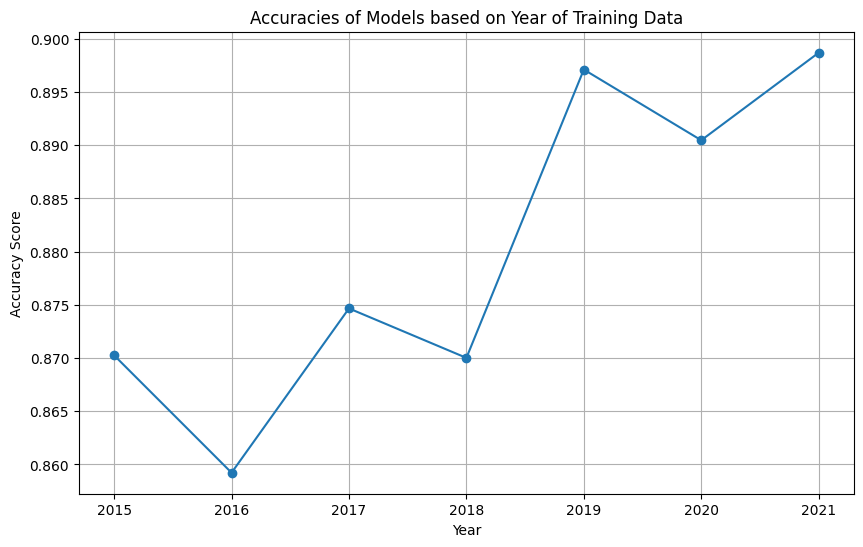

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(accuracies_x, accuracies_y,  marker='o')
plt.xlabel('Year')
plt.ylabel('Accuracy Score')
plt.title('Accuracies of Models based on Year of Training Data')
plt.grid(True)
plt.show()

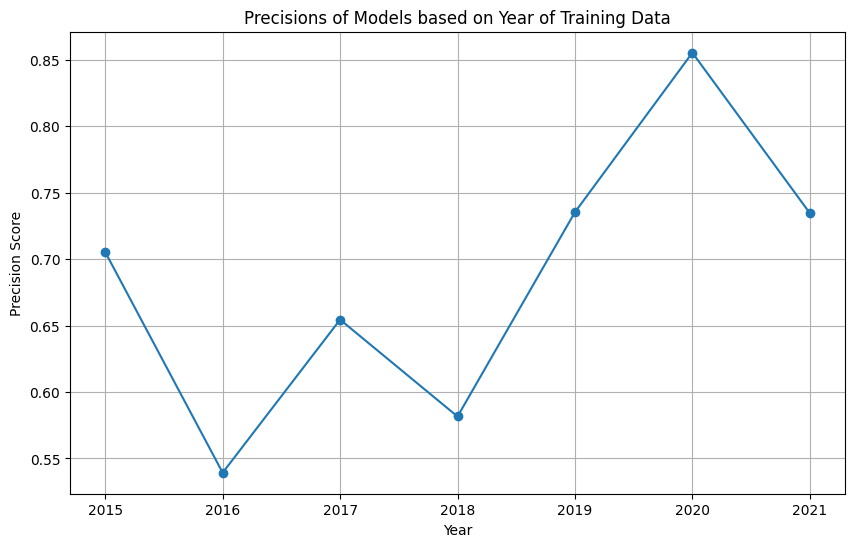

In [122]:
plt.figure(figsize=(10, 6))
plt.plot(precisions_x, precisions_y,  marker='o')
plt.xlabel('Year')
plt.ylabel('Precision Score')
plt.title('Precisions of Models based on Year of Training Data')
plt.grid(True)
plt.show()

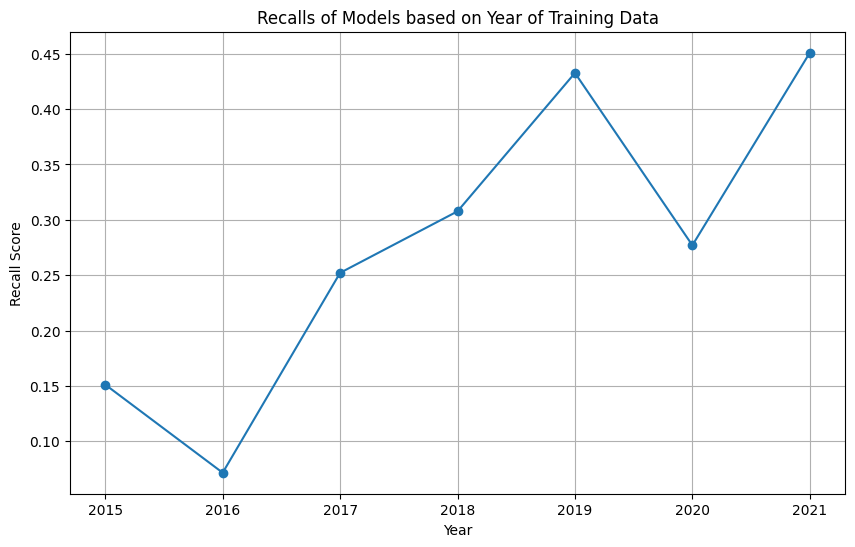

In [123]:
plt.figure(figsize=(10, 6))
plt.plot(recalls_x, recalls_y,  marker='o')
plt.xlabel('Year')
plt.ylabel('Recall Score')
plt.title('Recalls of Models based on Year of Training Data')
plt.grid(True)
plt.show()

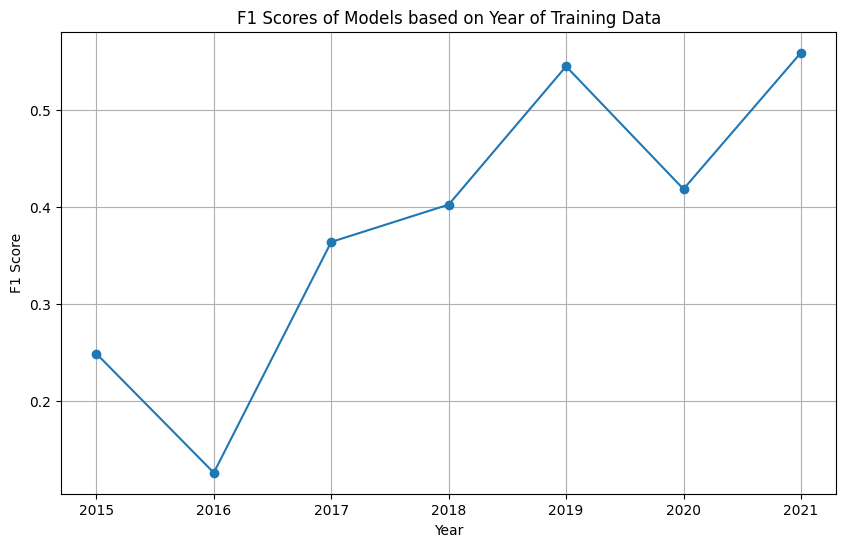

In [124]:
plt.figure(figsize=(10, 6))
plt.plot(f1s_x, f1s_y,  marker='o')
plt.xlabel('Year')
plt.ylabel('F1 Score')
plt.title('F1 Scores of Models based on Year of Training Data')
plt.grid(True)
plt.show()

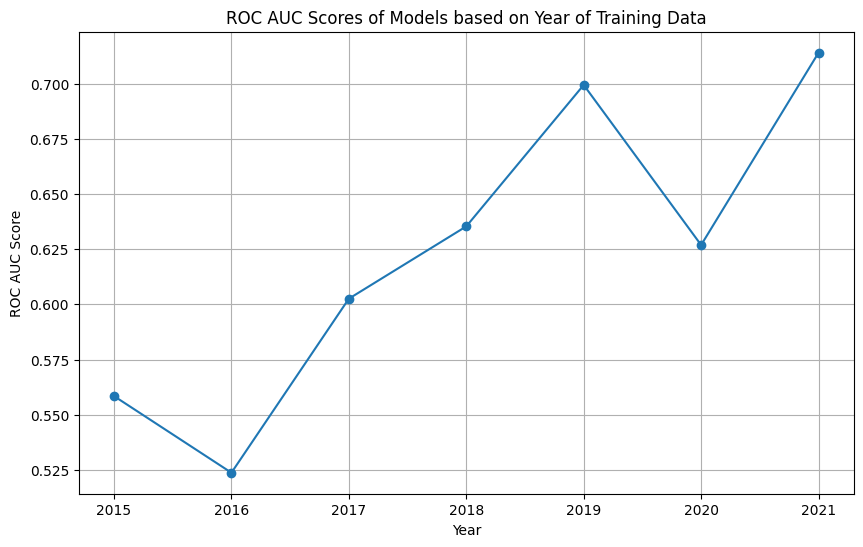

In [125]:
plt.figure(figsize=(10, 6))
plt.plot(roc_auc_x, roc_auc_y,  marker='o')
plt.xlabel('Year')
plt.ylabel('ROC AUC Score')
plt.title('ROC AUC Scores of Models based on Year of Training Data')
plt.grid(True)
plt.show()